# Example Pipeline for Lalonde

This notebook is a proof-of-concept for generating causal samples from external samples

In [1]:
import contextlib
import sys
import os
sys.path.append("../")  # go to parent dir
# sys.path.append("../data/analysis/")  # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF
from frugal_flows.benchmarking import FrugalFlowModel
from benchmarking import compare_datasets
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score


import data.template_causl_simulations as causl_py
import data.analysis.validationMethods as valMethods
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

seed = 0
N = 2000
B = 50
sampling_size = 1000
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

lalonde = pd.read_csv('../data/filtered_lalonde_dataset.csv')
lalonde = lalonde

outcome_col = 're78'
treatment_col = 'treatment'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = lalonde.loc[lalonde[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()



def rescale_outcome(x, mean, std):
    return x * std + mean
    
cont_columns = ['age']
disc_columns = ['education', 'black', 'hispanic', 'married', 'nodegree']

lalonde[standardised_outcome_col] = (lalonde[outcome_col] - Y_control_mean) / Y_control_std
for col in cont_columns:
    mean = lalonde[col].mean()
    std = lalonde[col].std()
    lalonde[col] = (lalonde[col] - mean) / std

X = jnp.array(lalonde[treatment_col].values)[:, None]
Y = jnp.array(lalonde[standardised_outcome_col].values)[:, None]

covariate_colnames = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree']
# Z_disc = jnp.array(lalonde[['black', 'hispanic', 'married', 'nodegree']].values)
Z_disc = jnp.array(lalonde[disc_columns].values)
Z_cont = jnp.array(lalonde[cont_columns].values)
# Z_disc = jnp.array(lalonde[covariate_colnames].values)

lalonde_rescaled = lalonde[
    [standardised_outcome_col, treatment_col] + covariate_colnames
]

In [2]:
marginal_hyperparam_dict = {
    'learning_rate': 5e-4,
    # 'learning_rate': 0.2,
    'RQS_knots': 8,
    'flow_layers': 3,
    'nn_depth': 5,    
    'nn_width': 10,
    'max_patience': 100,
    'max_epochs': 20000
}

hyperparam_dict = {
    'learning_rate': 0.006335,
    # 'learning_rate': 0.2,
    'RQS_knots': 4,
    'flow_layers': 9,
    'nn_depth': 10,    
    'nn_width': 50,
    'max_patience': 100,
    'max_epochs': 20000
}
causal_margin_hyperparams_dict = {
    'learning_rate': 0.005,
    'RQS_knots': 8,
    'flow_layers': 10,
    'nn_depth': 20,    
    'nn_width': 50,
    'max_epochs': 20000,
    'max_patience': 200,
}
seed=1

true_ATE = 1000
benchmark_flow = FrugalFlowModel(Y=Y, X=X, Z_disc=Z_disc, Z_cont=Z_cont, confounding_copula=None)
benchmark_flow.train_benchmark_model(
    training_seed=jr.PRNGKey(seed),
    marginal_hyperparam_dict=marginal_hyperparam_dict,
    frugal_hyperparam_dict=hyperparam_dict,
    causal_model='location_translation',
    causal_model_args={'ate': 0, **causal_margin_hyperparams_dict},
    prop_flow_hyperparam_dict=hyperparam_dict
)

  1%|▊                                                                                               | 162/20000 [00:10<22:04, 14.97it/s, train=-0.37894882852587297, val=-0.04905648347270639 (Max patience reached)]


### Unconfounded Data

In [3]:
sim_data_df = benchmark_flow.generate_samples(
    key=jr.PRNGKey(10*seed),
    sampling_size=600,
    copula_param=0.,
    outcome_causal_model='location_translation',
    outcome_causal_args={'ate': true_ATE / Y_control_std},
    with_confounding=False
)
sim_data_df.columns = lalonde_rescaled.columns

Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.


In [4]:
sim_data_df['treatment'].value_counts()

treatment
0.0    402
1.0    198
Name: count, dtype: int64

In [5]:
lalonde_rescaled['treatment'].value_counts()

treatment
0    429
1    185
Name: count, dtype: int64

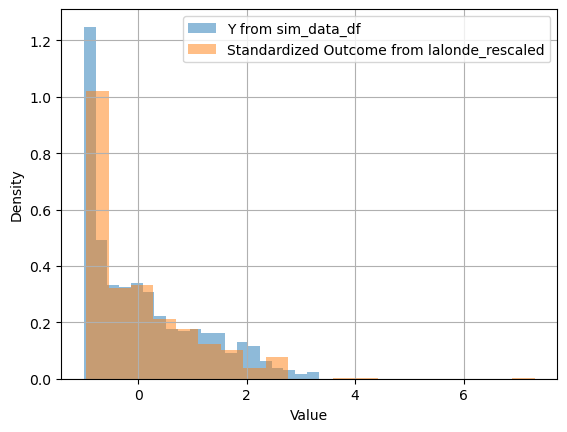

In [6]:
plotted_col = standardised_outcome_col#'education'
sim_data_df[plotted_col].hist(density=True, alpha=0.5, label='Y from sim_data_df', bins=20)
lalonde_rescaled[plotted_col].hist(density=True, alpha=0.5, label='Standardized Outcome from lalonde_rescaled', bins=20)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [7]:
lalonde_rescaled.head()

,re78_standardised,treatment,age,education,black,hispanic,married,nodegree
0,0.403868,1,0.975268,11,1,0,1,1
1,-0.464519,1,-0.542768,9,0,1,0,1
2,2.457483,1,0.266851,12,1,0,0,0
3,0.071561,1,-0.036756,11,1,0,0,1
4,-0.917772,1,0.570459,8,1,0,0,1


In [14]:
alphas = [0.1]#, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
k = 3
# cols = ['age', 'black', 'education']
cols = ["age", "education", "black", "hispanic", "married", "nodegree"]
# cols = ["treatment"]
lalonde_control = lalonde_rescaled.loc[lalonde_rescaled['treatment']==0]
sim_data_df_control = sim_data_df.loc[sim_data_df['treatment']==0]
compare_datasets(lalonde_rescaled.loc[:, cols].sample(300).values, sim_data_df_control.loc[:, cols].sample(300).values, alphas=alphas, k=3, n_permutations=1000)

Calculating Metrics...
MMD Calculated in 0.0072 seconds...
Energy Calculated in 0.0015 seconds...
FR Calculated in 0.0615 seconds...
KNN Calculated in 0.0191 seconds...
Total Metrics Calculation Time: 0.0906 seconds


{'MMD pval': 0.7799999713897705,
 'Energy pval': 0.8399999737739563,
 'Friedman-Rafsky pval': 0.0,
 'kNN pval': 0.00800000037997961}

In [9]:
lalonde_control[cols + [standardised_outcome_col]].corr()

,age,education,black,hispanic,married,nodegree,re78_standardised
age,1.000000,-0.147709,-0.091816,-0.058757,0.392305,-0.049730,0.110418
education,-0.147709,1.000000,-0.025374,-0.192752,-0.117401,-0.721906,0.161626
black,-0.091816,-0.025374,1.000000,-0.205347,-0.227508,0.048263,-0.147505
hispanic,-0.058757,-0.192752,-0.205347,1.000000,-0.030473,0.130603,0.006688
married,0.392305,-0.117401,-0.227508,-0.030473,1.000000,-0.012188,0.186111
nodegree,-0.049730,-0.721906,0.048263,0.130603,-0.012188,1.000000,-0.139766
re78_standardised,0.110418,0.161626,-0.147505,0.006688,0.186111,-0.139766,1.000000


In [10]:
sim_data_df[cols + [standardised_outcome_col]].corr()

,age,education,black,hispanic,married,nodegree,re78_standardised
age,1.000000,0.000117,-0.131344,-0.005573,0.280264,-0.100081,0.091923
education,0.000117,1.000000,0.010429,-0.055881,-0.089170,-0.648405,-0.057084
black,-0.131344,0.010429,1.000000,-0.062603,-0.259182,-0.002115,0.045069
hispanic,-0.005573,-0.055881,-0.062603,1.000000,0.021542,-0.038670,0.049379
married,0.280264,-0.089170,-0.259182,0.021542,1.000000,-0.041307,0.113523
nodegree,-0.100081,-0.648405,-0.002115,-0.038670,-0.041307,1.000000,0.054511
re78_standardised,0.091923,-0.057084,0.045069,0.049379,0.113523,0.054511,1.000000


Text(0.5, 1.0, 'Generated NSW Data')

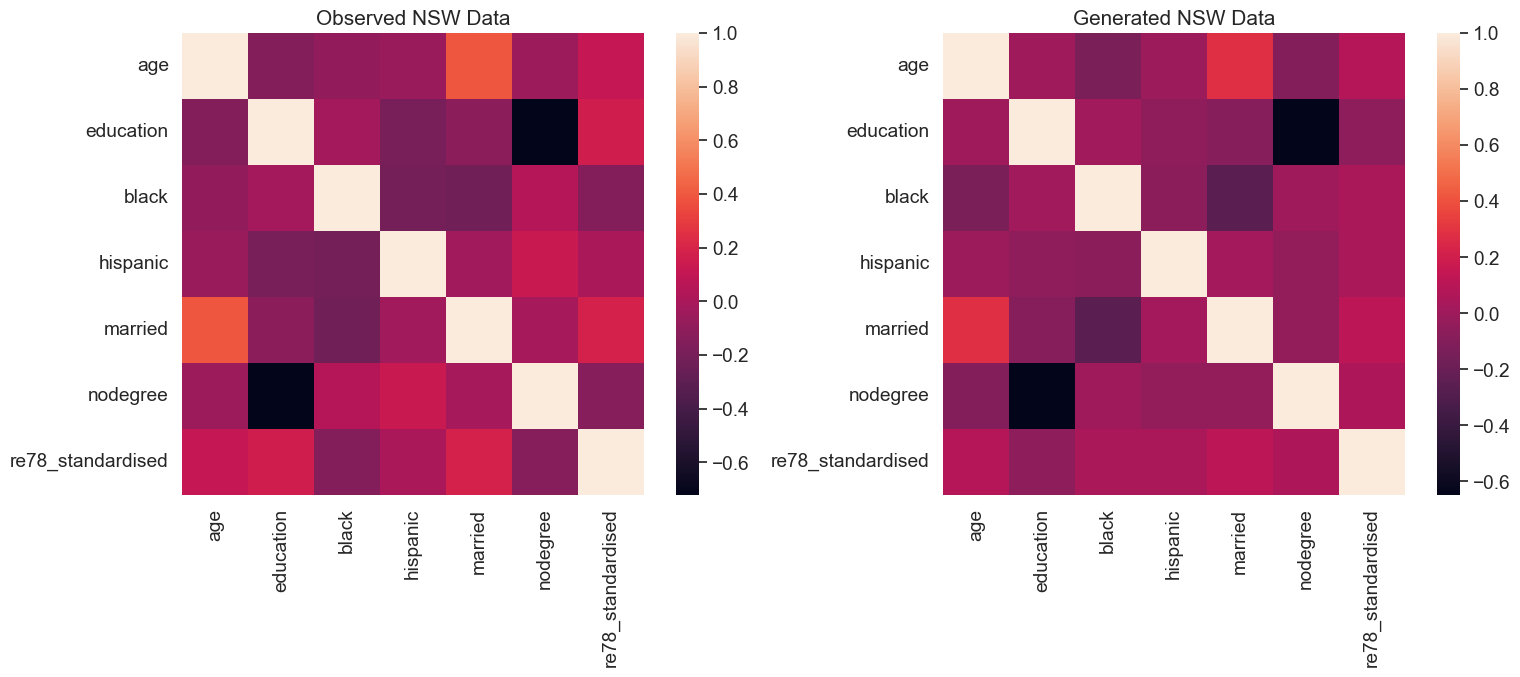

In [11]:
import seaborn as sns

sns.set(font_scale=1.25)
fig,ax = plt.subplots(ncols=2,figsize=(18,6))
sns.heatmap(lalonde_control[cols + [standardised_outcome_col]].corr(),ax=ax[0],square=True)
ax[0].set_title('Observed NSW Data')
sns.heatmap(sim_data_df[cols + [standardised_outcome_col]].corr(),ax=ax[1],square=True)
ax[1].set_title('Generated NSW Data')
# fig.savefig('Lalonde_NSW_0_1000_0.png')